In [1]:
%pylab inline
import netCDF4 as nc
import numpy as np
import os
import datetime as dt
import wradlib as wrl
import pylab as pl

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_IRIS_netcdf(filename, variable='Z', enforce_equidist=False):
    """Data reader for netCDF files exported by the IRIS radar software

    The netcdf files produced by the IRIS software usually contains two
    variables: reflectivity (Z) and total power (T). The default variable read
    is reflectivity.

    Parameters
    ----------
    filename : path of the netCDF file
    enforce_equidist : boolean
        Set True if the values of the azimuth angles should be forced to be equidistant
        default value is False

    Returns
    -------
    output : numpy array of image data (dBZ), dictionary of attributes

    """
    # read the data from file
    dset = nc.Dataset(filename)
    data = dset.variables[variable][:]
    # Check azimuth angles and rotate image
    az = dset.variables['radialAzim'][:]
    # These are the indices of the minimum and maximum azimuth angle
    ix_minaz = np.argmin(az)
    ix_maxaz = np.argmax(az)
##    if enforce_equidist:
##        az = np.linspace(np.round(az[ix_minaz],2), np.round(az[ix_maxaz],2), len(az))
##    else:
##        az = np.roll(az, -ix_minaz)
##    # rotate accordingly
##    data = np.roll(data, -ix_minaz, axis=0)
    data = np.where(data==dset.variables[variable].getncattr('_FillValue'), np.nan, data)
    # Ranges
    binwidth = dset.variables['gateSize'][:]
    r = np.arange(binwidth, (dset.variables['Z'].shape[-1]*binwidth) + binwidth, binwidth)
    # collect attributes
    attrs =  {}
    for attrname in dset.ncattrs():
        attrs[attrname] = dset.getncattr(attrname)

    # Set additional metadata attributes
    attrs['az'] = az
    attrs['r']  = r
    attrs['ElevationAngle'] = dset.variables['elevationAngle'][:]
    attrs['firstGateRange'] = dset.variables['firstGateRange'][:]
    attrs['gateSize'] = dset.variables['gateSize'][:]
    attrs['nyquist'] = dset.variables['nyquist'][:]
    attrs['unambigRange'] = dset.variables['unambigRange'][:]
    attrs['calibConst'] = dset.variables['calibConst'][:]
    attrs['Longitude'] = dset.variables['siteLat'][:]
    attrs['Latitude'] = dset.variables['siteLon'][:]
    attrs['sitecoords'] = (dset.variables['siteLat'][:], dset.variables['siteLon'][:], dset.variables['siteAlt'][:])
    attrs['Time'] = dt.datetime.utcfromtimestamp(dset.variables['esStartTime'][:])
    attrs['max_range'] = data.shape[1] * binwidth
    dset.close()

    return data, attrs

In [3]:
file = '../phirad-data/radars/baler/Output07BAL151017164814.RAW4G2N_sweep1.nc'
# BAL
data, attrs = read_IRIS_netcdf(file)

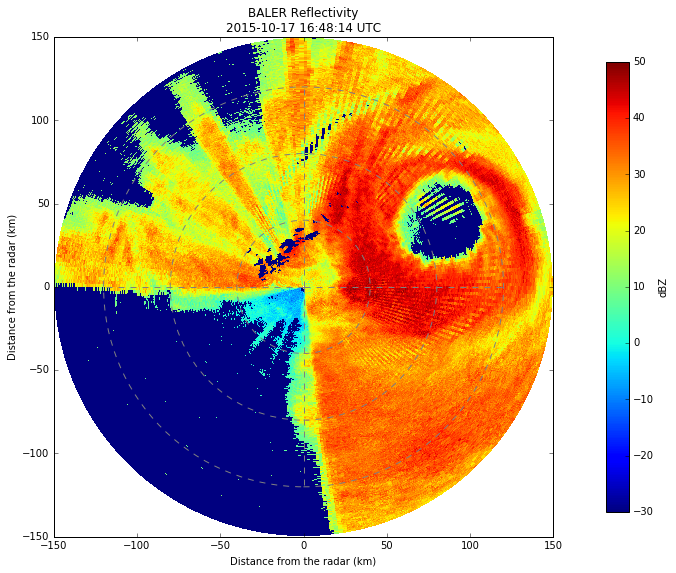

In [13]:
pl.figure(figsize=(15,8))

# reflectivity
pl.subplot(111)
ax,pm = wrl.vis.plot_ppi(np.ma.masked_invalid(data), r=attrs['r']/1000., vmin=-30, vmax=50)
wrl.vis.plot_ppi_crosshair(site=(0,0),ranges=[40,80,120])
cb = pl.colorbar(pm, shrink=0.9)
cb.set_label('dBZ')
pl.xlim((-150,150))
pl.ylim((-150,150))
pl.xlabel('Distance from the radar (km)')
pl.ylabel('Distance from the radar (km)')
pl.title('BALER Reflectivity\n' + str(attrs['Time']) + ' UTC')
pl.tight_layout()

In [5]:
attrs['max_range']

149125.0

In [6]:
data.shape

(360, 1193)

In [7]:
attrs['gateSize']

array(125.0, dtype=float32)

In [8]:
attrs['r'].max()

149125.0